## 1. Setup

In [33]:
# Better error messages in notebooks
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# Set up data paths

import sys
from pathlib import Path

# Get to project root from notebook location
PROJECT_ROOT = Path.cwd().parent
# Add "src" to Python's module search path sys.path
sys.path.append(str(PROJECT_ROOT / "src"))

# Define project paths
DATA_DIR = PROJECT_ROOT / "data"
CONFIG_DIR = PROJECT_ROOT / "configs"
RUNS_DIR = PROJECT_ROOT / "runs"

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Config directory: {CONFIG_DIR}")
print(f"Runs directory: {RUNS_DIR}")

Project root: /home/peterm/UWA/CITS5014/SARFish/modelling
Data directory: /home/peterm/UWA/CITS5014/SARFish/modelling/data
Config directory: /home/peterm/UWA/CITS5014/SARFish/modelling/configs
Runs directory: /home/peterm/UWA/CITS5014/SARFish/modelling/runs


In [41]:
# Setup and imports
%matplotlib inline
from sar_dataset import SARPreprocessedDataset
from letterbox_resize import letterbox_resize
from sar_yolo_simple_trainer import SimpleSARTrainer
from sar_evaluator import SARFloat32Evaluator

In [36]:
# Create data configuration
import yaml

data_config = {
    'path':   str(PROJECT_ROOT / 'data'), 
    'train':  'train',
    'val':    'val', 
    'test':   'test',
    'nc': 2,
    'names':  ['is_vessel', 'is_fishing']
}

# Save to configs directory
config_path = CONFIG_DIR / 'sar_data.yaml'
with open(config_path, 'w') as f:
    yaml.dump(data_config, f)

## 2. Model training

In [37]:
# Start TensorBoard in notebook
%load_ext tensorboard
%tensorboard --logdir {RUNS_DIR / 'train_no_aug'}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1809), started 2:53:41 ago. (Use '!kill 1809' to kill it.)

In [38]:
# Initialise trainer
trainer = SimpleSARTrainer(
    model_name='yolov8n.pt',
    data_yaml=str(CONFIG_DIR / 'sar_data.yaml'),
    imgsz=640,
    device='cuda',
    save_dir=RUNS_DIR / 'train_no_aug'
)

💾 Models will be saved to: /home/peterm/UWA/CITS5014/SARFish/modelling/runs/train_no_aug/20250721_130953
Using device: cuda
Train samples: 3114
Val samples: 463


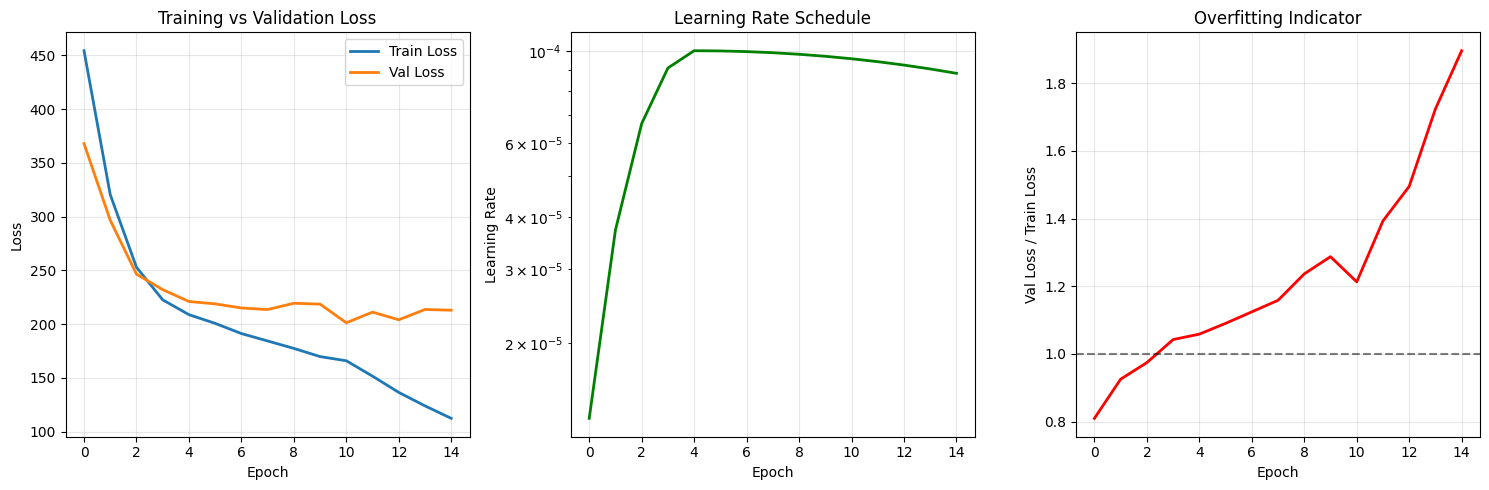


Epoch 16/50


Training:   0%|          | 0/195 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 102.4021
  Val Loss: 217.5785
  Learning Rate: 0.000086
  ⏳ Patience counter: 5/5

🛑 Early stopping triggered at epoch 16
  💾 Saved checkpoint: final.pt

Training completed!
Best validation loss: 201.1885
Final epoch: 16


In [39]:
# Train the model
history = trainer.train(
    epochs=50,  # Still testing
    batch_size=16,
    optimizer_type='adamw',
    lr=0.00001,
    workers=4,
    weight_decay=0.0005,  # L2 regularization
    use_warmup=True,  # Enable learning rate warmup
    use_progressive_unfreeze=True  # Enable progressive unfreezing
)

In [40]:
# Load best model
best_epoch, best_val_loss = trainer.load_best_model()
print(f"Loaded best model from epoch {best_epoch+1} with val loss {best_val_loss:.4f}")

Loaded best model from epoch 11
Loaded best model from epoch 11 with val loss 201.1885


## 3. Model Evaluation

In [60]:
# Initialize the evaluator
evaluator = SARFloat32Evaluator(
    model_path=RUNS_DIR / 'train_no_aug/20250721_130953/best.pt',
    #data_yaml_path=CONFIG_DIR / 'sar_data.yaml',
    data_yaml_path=config_path,
    device='cuda'
)

In [68]:
# Create the test dataset
with open(config_path, 'r') as f:
    data_dict = yaml.safe_load(f)

# Create test dataset manually
data_root = Path(data_dict['path'])
test_dataset = SARPreprocessedDataset(
    image_dir=str(data_root / 'test' / 'images'),  # or 'test' if using test
    label_dir=str(data_root / 'test' / 'labels'),
    imgsz=640
)

/home/peterm/UWA/CITS5014/SARFish/modelling/data


In [69]:
# Run evaluation
metrics = evaluator.evaluate_dataset(
    test_dataset,
    batch_size=32,
    conf_thres=0.25,
    iou_thres=0.45,
    save_dir=RUNS_DIR / 'evaluation_no_aug' / 'test_results'
)

Evaluating on 253 images...


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.36it/s]



Results saved to: /home/peterm/UWA/CITS5014/SARFish/modelling/runs/evaluation_no_aug/test_results
- metrics.json: Detailed metrics
- evaluation_results.png: Visualization


In [31]:
# Test inference on a single image
import torch
import numpy as np

# Load a test image
test_img_path = list((DATA_DIR / 'test' / 'images').glob('*.npy'))[0]
print(test_img_path)
test_img = np.load(test_img_path)

# Convert numpy image to a torch tensor and add a batch dimension with
# unsqueeze, then move the tensor to the approriate device (CPU or GPU)
test_img = torch.from_numpy(test_img).unsqueeze(0).to(trainer.device)

# Run inference
trainer.model.eval() # Sets the model to evaluation mode (disables dropout, uses running stats for batch normalization)
with torch.no_grad(): # Disables gradient computation for efficiency during inference
    predictions = trainer.model(test_img)

# Print the shape of predictions—taking care to handle tuple output (like in YOLO-style heads).    
print(f"Predictions shape: {predictions[1][0].shape if isinstance(predictions, tuple) else predictions.shape}")

/home/peterm/UWA/CITS5014/SARFish/modelling/data/test/images/8204efcfe9f09f94v_044.97495057999999801268_013.22696544999999979098_swath2_proc.npy
Predictions shape: torch.Size([1, 144, 12, 12])


## 4. Model Inspection

In [16]:
# List all layers of the 'yolov8n.pt' model with their indices
for i, (name, param) in enumerate(trainer.model.named_parameters()):
    print(f"{i:3d}: {name:50s} shape={list(param.shape)}")
    if i > 30:  # Just show first 30
        print("...")
        break

  0: model.model.0.conv.weight                          shape=[16, 3, 3, 3]
  1: model.model.0.bn.weight                            shape=[16]
  2: model.model.0.bn.bias                              shape=[16]
  3: model.model.1.conv.weight                          shape=[32, 16, 3, 3]
  4: model.model.1.bn.weight                            shape=[32]
  5: model.model.1.bn.bias                              shape=[32]
  6: model.model.2.cv1.conv.weight                      shape=[32, 32, 1, 1]
  7: model.model.2.cv1.bn.weight                        shape=[32]
  8: model.model.2.cv1.bn.bias                          shape=[32]
  9: model.model.2.cv2.conv.weight                      shape=[32, 48, 1, 1]
 10: model.model.2.cv2.bn.weight                        shape=[32]
 11: model.model.2.cv2.bn.bias                          shape=[32]
 12: model.model.2.m.0.cv1.conv.weight                  shape=[16, 16, 3, 3]
 13: model.model.2.m.0.cv1.bn.weight                    shape=[16]
 14: model.mo